# Notebook Lecture 1: Introduction, Digital Control Systems
© 2025 ETH Zurich, Niclas Scheuer; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

This interactive notebook covers the basics of discrete-time control and aliasing.

Authors:
- Niclas Scheuer; nscheuer@ethz.ch

## Import the packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.optimize import curve_fit
from IPython.display import display

# Example 1: Zero-Order Hold

The zero-order hold is perhaps the simplest method to turn a _discrete-time_ (DT) signal into a _continuous-time_ (CT) signal. It does this by taking the value of the input at time $$t_k = kT$$ and holding this output for the whole sampling period $$t \in [kT, (k+1)T)$$



In [7]:
def zero_order_hold_plot(fs):
    T = 2  # Total time in seconds
    t_cont = np.linspace(0, T, 1000)  # Continuous time axis
    signal_cont = np.sin(2 * np.pi * 1 * t_cont)  # Continuous sine wave
    
    t_samples = np.arange(0, T, 1/fs)  # Discrete sample times
    signal_samples = np.sin(2 * np.pi * 1 * t_samples)  # Sampled signal
    
    # Create ZOH signal by repeating each sample value until the next sample
    t_zoh = np.repeat(t_samples, 2)
    signal_zoh = np.repeat(signal_samples, 2)
    
    # Adjust last element to match the original timeline
    t_zoh = np.append(t_zoh, T)
    signal_zoh = np.append(signal_zoh, signal_zoh[-1])
    
    plt.figure(figsize=(8, 4))
    plt.plot(t_cont, signal_cont, 'b', label='Original Signal')  # Continuous signal
    plt.step(t_zoh, signal_zoh, 'r', where='post', label='Zero-Order Hold')  # ZOH signal
    plt.scatter(t_samples, signal_samples, color='black', zorder=3, label='Samples')  # Sample points
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Zero-Order Hold (Sampling Frequency = {fs} Hz)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create slider for sampling frequency
fs_slider = widgets.IntSlider(min=1, max=30, step=1, value=5, description='Fs (Hz)')
interactive_plot = widgets.interactive_output(zero_order_hold_plot, {'fs': fs_slider})
display(fs_slider, interactive_plot)


IntSlider(value=5, description='Fs (Hz)', max=30, min=1)

Output()

# Example 2: Nyquist-Shannon Sampling Theorem

If we don't sample a signal often enough, we lose important details, making it hard to reconstruct the original signal.

## Sinuisoidal Signals and Sampling
Since any signal can be broken down into sine waves using the Fourier transform, we use a basic sinusoidal signal to explain the Nyquist-Shannon Sampling Theorem.

## Nyquist-Shannon Sampling Theorem
A sampled signal can be perfectly reconstructed only if the sampling rate is at least twice the highest frequency present in the signal.

$$
f_s \geq 2f_{max}
$$

where:
- $f_s$ is the **sampling frequency**
- $f_{max}$ is the **highest frequency component** in the signal





In [8]:
# Function to generate a sinusoidal signal
def sinusoid(t, f):
    return np.sin(2 * np.pi * f * t)

# Function to fit a sinusoid to sampled points using the lowest frequency possible
def fit_sinusoid(t_samples, y_samples, f_s):
    def model(t, A, f_fit, phase):
        return A * np.sin(2 * np.pi * f_fit * t + phase)
    
    # Nyquist folding to find the aliased frequency
    f_alias = np.abs((f_samples := np.fft.fftfreq(len(t_samples), d=(t_samples[1] - t_samples[0])))[np.argmax(np.abs(np.fft.fft(y_samples)))])
    f_guess = f_alias if f_alias < f_s / 2 else f_s - f_alias
    
    params, _ = curve_fit(model, t_samples, y_samples, p0=[1, f_guess, 0])
    return lambda t: model(t, *params)

# Interactive function to update the plot
def nyquist_plot(f_max, f_s):
    T = 1  # Total duration (1 second)
    t_cont = np.linspace(0, T, 1000)  # High-resolution time for continuous signal
    y_cont = sinusoid(t_cont, f_max)  # Continuous signal

    # Sampling points
    t_samples = np.arange(0, T, 1/f_s)  # Sampled times
    y_samples = sinusoid(t_samples, f_max)  # Sampled values

    # Fit a sinusoid to sampled points
    fitted_sinusoid = fit_sinusoid(t_samples, y_samples, f_s)

    # Generate reconstructed signal
    y_reconstructed = fitted_sinusoid(t_cont)

    # Plot the results
    plt.figure(figsize=(8, 4))
    plt.plot(t_cont, y_cont, 'b', label='Original Signal')  # Continuous signal
    plt.scatter(t_samples, y_samples, color='red', zorder=3, label='Sampled Points')  # Sampled points
    plt.plot(t_cont, y_reconstructed, 'g--', label='Reconstructed Signal')  # Fitted sinusoid
    
    # Nyquist Criterion Check
    nyquist_condition = f_s >= 2 * f_max
    condition_text = "✓ Nyquist Theorem Fulfilled" if nyquist_condition else "✗ Undersampling (Aliasing Can Occur!)"
    plt.title(f'Nyquist-Shannon Sampling Theorem\n{condition_text}', fontsize=12, color='green' if nyquist_condition else 'red')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders
f_max_slider = widgets.FloatSlider(min=1, max=10, step=0.5, value=3, description='f_max (Hz)')
f_s_slider = widgets.FloatSlider(min=2, max=20, step=0.5, value=6, description='f_s (Hz)')

# Display interactive plot
interactive_plot = widgets.interactive_output(nyquist_plot, {'f_max': f_max_slider, 'f_s': f_s_slider})
display(f_max_slider, f_s_slider, interactive_plot)


FloatSlider(value=3.0, description='f_max (Hz)', max=10.0, min=1.0, step=0.5)

FloatSlider(value=6.0, description='f_s (Hz)', max=20.0, min=2.0, step=0.5)

Output()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq
import ipywidgets as widgets
from IPython.display import display

# Global storage for the original signal
global_t_cont = np.linspace(0, 1, 1000)  # High-resolution time
global_freq_options = np.array([1, 2, 5, 10, 20])  # Available frequency components
global_num_components = 2  # Default number of harmonics
global_f_s = 20  # Default sampling frequency

def generate_signal(num_components):
    global global_freqs, global_amps, global_phases, global_y_cont
    global_freqs = global_freq_options[:num_components]
    global_amps = np.ones(len(global_freqs))
    global_phases = np.random.uniform(0, 2*np.pi, len(global_freqs))
    global_y_cont = sum(A * np.sin(2 * np.pi * f * global_t_cont + p) for A, f, p in zip(global_amps, global_freqs, global_phases))

generate_signal(global_num_components)

# Function to fit multiple sinusoids to sampled points
def fit_sinusoids(t_samples, y_samples, freqs):
    def model(t, *params):
        A = params[:len(freqs)]
        P = params[len(freqs):]
        return sum(A[i] * np.sin(2 * np.pi * freqs[i] * t + P[i]) for i in range(len(freqs)))
    
    p0 = [1] * len(freqs) + [0] * len(freqs)  # Initial guess: Amplitudes = 1, Phases = 0
    params, _ = curve_fit(model, t_samples, y_samples, p0=p0)
    return lambda t: model(t, *params)

# Function to plot Nyquist sampling with complex signals
def nyquist_plot():
    T = 1  # Total duration (1 second)
    num_samples = int(T * global_f_s)  # Adjust number of samples dynamically
    t_samples = np.linspace(0, T, num_samples, endpoint=False)
    y_samples = sum(A * np.sin(2 * np.pi * f * t_samples + p) for A, f, p in zip(global_amps, global_freqs, global_phases))

    # Reconstructed signal
    fitted_sinusoids = fit_sinusoids(t_samples, y_samples, global_freqs)
    y_reconstructed = fitted_sinusoids(global_t_cont)

    # Nyquist Criterion Check
    max_freq = max(global_freqs)
    nyquist_condition = global_f_s >= 2 * max_freq
    condition_text = "\n\n✓ Nyquist Theorem Fulfilled" if nyquist_condition else "\n\n✗ Undersampling (Aliasing Occurs!)"

    # Plot time domain
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.title(f'Nyquist-Shannon Sampling Theorem {condition_text}', fontsize=12, color='green' if nyquist_condition else 'red')
    plt.plot(global_t_cont, global_y_cont, 'b', label='Original Signal')
    plt.scatter(t_samples, y_samples, color='red', zorder=3, label='Sampled Points')
    plt.plot(global_t_cont, y_reconstructed, 'g--', label='Reconstructed Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # Fourier Transform Analysis
    N = 4096  # Increase FFT size for better resolution
    freqs_cont = fftfreq(N, d=(global_t_cont[1] - global_t_cont[0]))
    spectrum_cont = np.abs(fft(global_y_cont, n=N))
    spectrum_cont /= np.max(spectrum_cont)  # Normalize original spectrum
    
    N_samples = 4096  # Ensure FFT resolution matches
    freqs_samples = fftfreq(N_samples, d=(t_samples[1] - t_samples[0]))
    spectrum_samples = np.abs(fft(y_samples, n=N_samples))
    spectrum_samples /= np.max(spectrum_samples)  # Normalize sampled spectrum
    
    plt.subplot(2, 1, 2)
    plt.plot(freqs_cont[:N//2], spectrum_cont[:N//2], 'b', label='Original Spectrum')
    plt.plot(freqs_samples[:N_samples//2], spectrum_samples[:N_samples//2], 'r--', label='Sampled Spectrum')
    plt.xlim(0, 40)  # Limit frequency axis to 40 Hz
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Magnitude')
    plt.legend()
    plt.grid(True)

    # Annotate expected peaks
    for f in global_freqs:
        plt.axvline(f, color='gray', linestyle='dashed', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Interactive controls
num_components_slider = widgets.IntSlider(min=1, max=len(global_freq_options), step=1, value=global_num_components, description='Harmonics')
f_s_slider = widgets.FloatSlider(min=5, max=50, step=1, value=global_f_s, description='f_s (Hz)')

def update_plot(num_components, f_s):
    global global_f_s
    if num_components != len(global_freqs):
        generate_signal(num_components)
    global_f_s = f_s
    nyquist_plot()

interactive_plot = widgets.interactive_output(update_plot, {'num_components': num_components_slider, 'f_s': f_s_slider})
display(num_components_slider, f_s_slider, interactive_plot)


IntSlider(value=2, description='Harmonics', max=5, min=1)

FloatSlider(value=20.0, description='f_s (Hz)', max=50.0, min=5.0, step=1.0)

Output()

FloatSlider(value=14.0, description='f_s (Hz)', max=50.0, min=1.0, step=1.0)

Output()

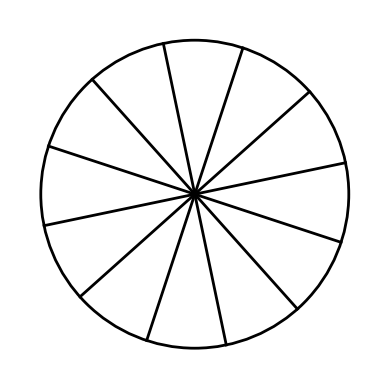

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider
from IPython.display import display, HTML


# Global parameters
num_spokes = 12  # Number of spokes on the wheel
wheel_radius = 1  # Radius of the wheel
rotation_speed = 90/ 1000  # Degrees per ms
global_f_s = 14  # Default sampling frequency (FPS)

# Create figure and axis
fig, ax = plt.subplots()

def draw_wheel(angle):
    """Function to draw the rotating wheel at a given angle."""
    ax.clear()
    ax.set_xlim(-wheel_radius - 0.2, wheel_radius + 0.2)
    ax.set_ylim(-wheel_radius - 0.2, wheel_radius + 0.2)
    ax.set_aspect('equal')
    ax.axis('off')

    # Draw the wheel circle
    circle = plt.Circle((0, 0), wheel_radius, color='black', fill=False, linewidth=2)
    ax.add_patch(circle)

    # Draw spokes
    for i in range(num_spokes):
        theta = np.radians(i * (360 / num_spokes) + angle)
        x = wheel_radius * np.cos(theta)
        y = wheel_radius * np.sin(theta)
        ax.plot([0, x], [0, y], 'k', linewidth=2)


# Animation function
def animate(frame):
    """Function to animate the wheel based on the current FPS."""
    # global global_f_s
    # fps = global_f_s  # Get current slider value
    # angle = -(frame * rotation_speed * (24 / fps)) % 360  # Adjust for aliasing effect
    angle =  - frame * rotation_speed *  int(1000/global_f_s)
    draw_wheel(angle)

def update_plot( f_s):
    global global_f_s
    global_f_s = f_s
    ani = animation.FuncAnimation(fig=fig, func=animate, frames=int(10*global_f_s), interval=int(1000/global_f_s))
    display( HTML(ani.to_jshtml()))

# Interactive slider for FPS (Sampling Frequency)
f_s_slider = widgets.FloatSlider(min=1, max=50, step=1, value=global_f_s, description='f_s (Hz)')

interactive_plot = widgets.interactive_output(update_plot, {'f_s': f_s_slider})
display(f_s_slider, interactive_plot)
